## Kết nối đến thư mục Google Drive

In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
import os
project_path = '/content/drive/MyDrive/EdgeAIK03/M13K03_EdgeAI_MachineLearning_2'
os.chdir(project_path)

print("Current working directory:", os.getcwd())

Current working directory: /content/drive/MyDrive/EdgeAIK03/M13K03_EdgeAI_MachineLearning_2


### Đọc Data và chia nhóm

#### Load data từ File đã trích xuất đặc trưng từ trước

In [45]:
import glob
import os
import numpy as np

labels = ['helloworld', 'unknown', 'noise']

data_lst = []
label_lst = []

for npy_path in glob.glob(r'Responding2YourVoice/features/*.npy'):
  x = np.load(npy_path)
  y = os.path.basename(npy_path).split('.')[0].lower()
  if y in labels:
    data_lst.append(x)
    label_lst.append(labels.index(y))

# print(list(set(label_lst)))
data_lst = np.array(data_lst)
label_lst = np.array(label_lst)

print(f'Tổng số mẫu: {data_lst.shape}')
print(f'Mẫu dữ liệu ({data_lst[0].shape}): {data_lst[0]} {label_lst[0]}')

Tổng số mẫu: (2062, 13, 51)
Mẫu dữ liệu ((13, 51)): [[0.         0.01516109 0.01692718 0.00526909 0.0089941  0.00871372
  0.04403279 0.01369432 0.34818566 0.24247304 0.25747752 0.18584163
  0.14071858 0.14139725 0.35507023 0.4097649  0.4829987  0.5292272
  0.46396133 0.42679262 0.3917643  0.45500016 0.4968134  0.5063302
  0.50469834 0.47304162 0.4584203  0.42114994 0.41366583 0.37109867
  0.33827478 0.32014462 0.31057933 0.3370555  0.3741409  0.3737396
  0.36940303 0.36941892 0.3610373  0.37475777 0.3444654  0.31374115
  0.2835711  0.24846122 0.22537123 0.20196338 0.19994862 0.22255409
  0.26166135 0.27230072 0.25234696]
 [0.8204611  0.83101195 0.8376301  0.82408214 0.8274867  0.8296312
  0.7795212  0.8165536  0.69254774 0.7099419  0.7788517  0.786523
  0.80926687 0.85683346 0.9764858  0.9821499  0.9477578  0.93609834
  0.9488382  0.9523756  0.96634483 0.93094325 0.9129493  0.90567607
  0.9122759  0.92688245 0.93926924 0.94730335 0.94147307 0.9212134
  0.9479741  0.9614546  0.96744686 

#### Chia tập dữ liệu thành tập Train (70%), Valid (15%), Test (15%)

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X_train, X_test_val, y_train, y_test_val = train_test_split(data_lst, label_lst, test_size=0.3, stratify=label_lst)
X_val, X_test, y_val, y_test = train_test_split(X_test_val, y_test_val, test_size=0.5, stratify=y_test_val)

# Print status
print("X train shape: {} \t X val shape: {} \t X test shape: {}".format(X_train.shape, X_val.shape, X_test.shape))
print("y train shape: {} \t y val shape: {} \t y test shape: {}".format(y_train.shape, y_val.shape, y_test.shape))

train_labels, train_counts = np.unique(y_train, return_counts=True)
val_labels, val_counts = np.unique(y_val, return_counts=True)
test_labels, test_counts = np.unique(y_test, return_counts=True)
print("Train label distribution:", dict(zip(train_labels, train_counts)))
print("Val label distribution:", dict(zip(val_labels, val_counts)))
print("Test label distribution:", dict(zip(test_labels, test_counts)))

X train shape: (1443, 13, 51) 	 X val shape: (309, 13, 51) 	 X test shape: (310, 13, 51)
y train shape: (1443,) 	 y val shape: (309,) 	 y test shape: (310,)
Train label distribution: {0: 435, 1: 504, 2: 504}
Val label distribution: {0: 93, 1: 108, 2: 108}
Test label distribution: {0: 93, 1: 109, 2: 108}


#### Tạo Object Dataset

In [47]:
import numpy as np
import torch
from torch.utils.data import Dataset

class Responding2YourVoiceDataset(Dataset):
    def __init__(self, data, labels, num_classes):
        self.data = data  # Dữ liệu đầu vào
        self.labels = labels  # phân loại tương ứng
        self.num_classes = num_classes

    def __len__(self):
        return len(self.data)  # Số lượng mẫu trong dataset

    def __getitem__(self, idx):
        # Trả về một cặp (dữ liệu, nhãn) cho chỉ số idx
        # waveform = np.load(self.data[idx])
        sample = torch.tensor(self.data[idx], dtype=torch.float32)  # Chuyển data thành tensor
        label = torch.tensor(self.labels[idx], dtype=torch.long)  # Chuyển label thành tensor
        return sample, label

In [48]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = Responding2YourVoiceDataset(X_train, y_train, 3)
val_dataset = Responding2YourVoiceDataset(X_val, y_val, 3)
test_dataset = Responding2YourVoiceDataset(X_test, y_test, 3)

### Tạo Model

#### Cấu hình Model

In [49]:
import torch.nn as nn


class Responding2YourVoiceModel(nn.Module):
    def __init__(self, input_length, num_classes):
        super(Responding2YourVoiceModel, self).__init__()
        rows, columns = input_length
        self.num_classes = num_classes

        self.reshape = lambda x: x.view(x.size(0), 1, rows, columns)

        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding='same')
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout1 = nn.Dropout(0.25)

        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding='same')
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout2 = nn.Dropout(0.25)
        # Calculate flattened input size after convolutions
        flattened_size = ((rows // 4) * (columns // 4)) * 16
        self.fc = nn.Linear(flattened_size, num_classes)
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):
        x = self.reshape(x)
        x = self.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = self.dropout1(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = self.dropout2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.softmax(x)
        return x

#### Hiển thị model

In [50]:
!pip install torchsummary

In [51]:
from torchsummary import summary

input_length = [13, 51]
model = Responding2YourVoiceModel(input_length, 3)
model.to(device)
# Hiển thị cấu trúc của mô hình
summary(model, input_size=tuple([1] + input_length))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 13, 51]              80
              ReLU-2            [-1, 8, 13, 51]               0
         MaxPool2d-3             [-1, 8, 6, 25]               0
           Dropout-4             [-1, 8, 6, 25]               0
            Conv2d-5            [-1, 16, 6, 25]           1,168
              ReLU-6            [-1, 16, 6, 25]               0
         MaxPool2d-7            [-1, 16, 3, 12]               0
           Dropout-8            [-1, 16, 3, 12]               0
            Linear-9                    [-1, 3]           1,731
          Softmax-10                    [-1, 3]               0
Total params: 2,979
Trainable params: 2,979
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.14
Params size (MB): 0.01
Estimated Total

### Tạo Loss Function, Optimizer, Training

#### Thiết lập thông số Train

In [52]:
learning_rate = 0.001  # Tốc độ học
epochs = 500  # Số chu kỳ huấn luyện
batch_size = 32  # Số dữ liệu cho 1 batch

#### Khởi tạo

In [53]:
import torch.optim as optim
import torch.nn as nn
import torch
from torch.utils.data import DataLoader

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### Huấn luyện

In [54]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_model_path = 'Responding2YourVoice/best_model.pth'

# Biến kiểm soát early stopping
best_val_loss = float('inf')
best_val_epoch = 0
epochs_no_improve = 0
early_stop_patience = 50  # Số epoch không cải thiện trước khi dừng sớm

for epoch in range(epochs):
  model.train()
  running_loss = 0.0
  correct_train = 0
  total_train = 0

  for waves, lbs in train_loader:
    waves, lbs = waves.to(device), lbs.to(device)

    ## train
    optimizer.zero_grad()

    outputs = model(waves)
    loss = criterion(outputs, lbs)
    loss.backward()
    optimizer.step()

    ## Đánh giá trên tập dữ liệu Train
    running_loss += loss.item()

    _, predicted = torch.max(outputs, 1)
    total_train += lbs.size(0)
    correct_train += (predicted == lbs).sum().item()

  # Tính train loss và accuracy
  train_loss = running_loss / len(train_loader)
  train_accuracy = 100 * correct_train / total_train
  train_losses.append(train_loss)
  train_accuracies.append(train_accuracy)

  # Đánh giá trên tập Val
  model.eval()  # Chuyển mô hình sang chế độ đánh giá
  val_loss = 0.0
  correct_val = 0
  total_val = 0
  with torch.no_grad():
    for waves, lbs in val_loader:
      waves, lbs = waves.to(device), lbs.to(device)

      outputs = model(waves)
      loss = criterion(outputs, lbs)
      val_loss += loss.item()

      # Tính accuracy cho validation
      _, predicted = torch.max(outputs, 1)
      total_val += lbs.size(0)
      correct_val += (predicted == lbs).sum().item()

  # Tính validation loss và accuracy
  val_loss /= len(val_loader)
  val_accuracy = 100 * correct_val / total_val
  val_losses.append(val_loss)
  val_accuracies.append(val_accuracy)

  print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

  # Kiểm tra và lưu mô hình tốt nhất
  if val_loss < best_val_loss:
    best_val_loss = val_loss
    best_val_epoch = epoch
    torch.save(model.state_dict(), best_model_path)  # Lưu mô hình tốt nhất
    print("Validation loss tốt nhất, lưu model.")
    epochs_no_improve = 0  # Reset số epoch không cải thiện
  else:
    epochs_no_improve += 1
    # print(f"Validation loss did not improve for {epochs_no_improve} epoch(s).")

  # Dừng sớm nếu không có cải thiện trong `early_stop_patience` epoch
  if epochs_no_improve >= early_stop_patience:
    print("Early stopping: Validation loss không thay đổi thêm.")
    break

# Tải mô hình tốt nhất sau khi huấn luyện
print(f'Kết thúc huấn luyện. Load weights tốt nhất ở chu kỳ {best_val_epoch}')
model.load_state_dict(torch.load(best_model_path))
model.eval()  # Chuyển mô hình sang chế độ đánh giá

Epoch 1/500, Train Loss: 1.0950, Train Accuracy: 35.00%, Validation Loss: 1.0930, Validation Accuracy: 34.95%
Validation loss tốt nhất, lưu model.
Epoch 2/500, Train Loss: 1.0916, Train Accuracy: 37.63%, Validation Loss: 1.0900, Validation Accuracy: 34.95%
Validation loss tốt nhất, lưu model.
Epoch 3/500, Train Loss: 1.0881, Train Accuracy: 36.73%, Validation Loss: 1.0795, Validation Accuracy: 34.63%
Validation loss tốt nhất, lưu model.
Epoch 4/500, Train Loss: 1.0783, Train Accuracy: 39.15%, Validation Loss: 1.0676, Validation Accuracy: 50.49%
Validation loss tốt nhất, lưu model.
Epoch 5/500, Train Loss: 1.0586, Train Accuracy: 43.73%, Validation Loss: 1.0423, Validation Accuracy: 54.69%
Validation loss tốt nhất, lưu model.
Epoch 6/500, Train Loss: 1.0398, Train Accuracy: 48.44%, Validation Loss: 1.0421, Validation Accuracy: 46.93%
Validation loss tốt nhất, lưu model.
Epoch 7/500, Train Loss: 1.0170, Train Accuracy: 52.39%, Validation Loss: 1.0420, Validation Accuracy: 47.90%
Validati

<ipython-input-54-8897caaea26a>:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Responding2YourVoiceModel(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (relu): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=576, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

#### Vẽ đồ thị quá trình huấn luyện

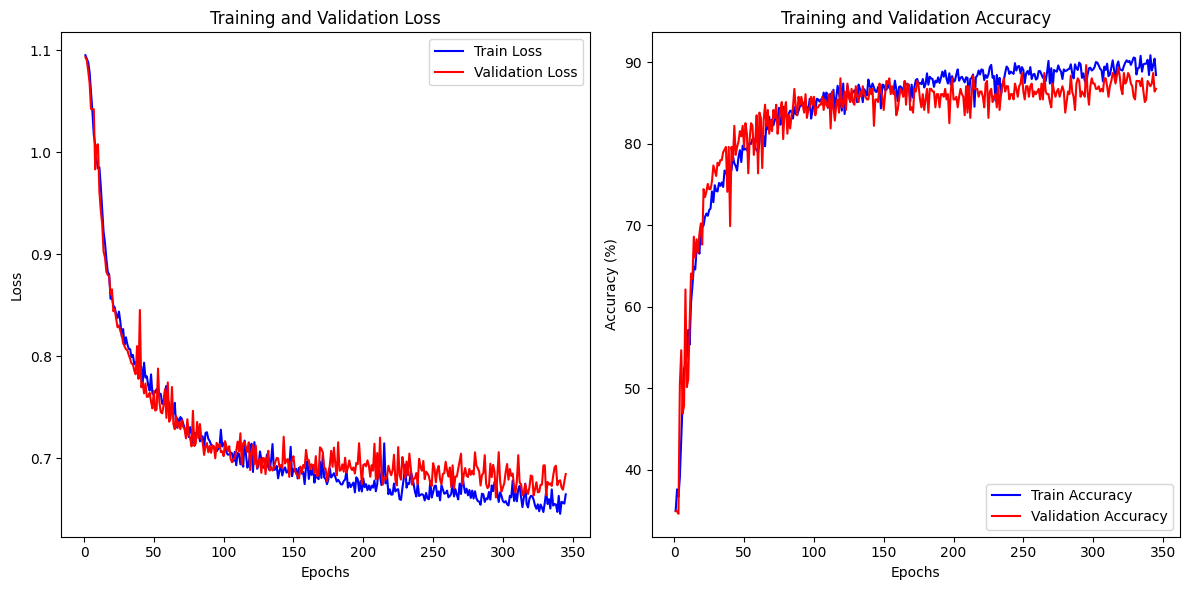

In [55]:
import matplotlib.pyplot as plt

# Vẽ đồ thị Loss và Accuracy
# Vẽ đồ thị Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Vẽ đồ thị Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()


#### Đánh giá mô hình

In [56]:
# Đánh giá trên tập kiểm tra (test)
all_lbs = []
all_predictions = []
with torch.no_grad():
  model.eval()
  for waves, lbs in test_loader:
    waves, lbs = waves.to(device), lbs.to(device)

    outputs = model(waves)
    _, predicted = torch.max(outputs, 1)

    all_lbs.extend(lbs.cpu().numpy())
    all_predictions.extend(predicted.cpu().numpy())

<Figure size 800x800 with 0 Axes>

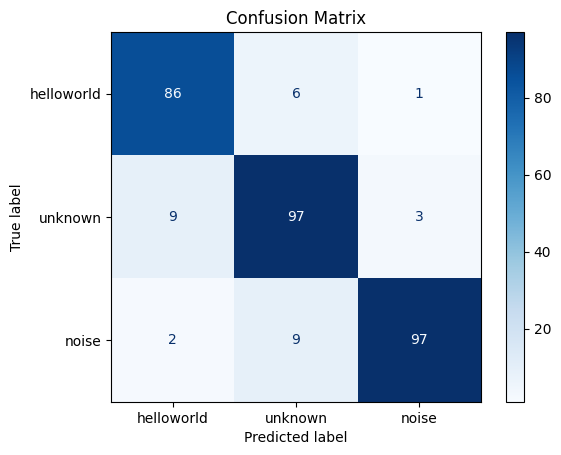

Precision: 0.91
Recall: 0.90
F1 Score: 0.90

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.91        93
           1       0.87      0.89      0.88       109
           2       0.96      0.90      0.93       108

    accuracy                           0.90       310
   macro avg       0.90      0.90      0.90       310
weighted avg       0.91      0.90      0.90       310



In [57]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Tính ma trận nhầm lẫn
cm = confusion_matrix(all_lbs, all_predictions)

# Hiển thị ma trận nhầm lẫn
plt.figure(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

precision = precision_score(all_lbs, all_predictions, average='weighted')
recall = recall_score(all_lbs, all_predictions, average='weighted')
f1 = f1_score(all_lbs, all_predictions, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# In báo cáo chi tiết
print("\nClassification Report:")
print(classification_report(all_lbs, all_predictions))


#### Chạy thử model

In [61]:
import torch
import random

idx = random.randint(0, len(X_test))

model.eval()
x = torch.tensor(X_test[idx], dtype=torch.float32).unsqueeze(0).to(device)
y = torch.tensor(y_test[idx], dtype=torch.long).to(device)

with torch.no_grad():
  output = model(x)
  _, predicted = torch.max(output, 1)  # Lấy nhãn dự đoán
print(f'y_target: {y} | y_predict: {predicted} ({output})')

y_target: 0 | y_predict: tensor([0], device='cuda:0') (tensor([[9.2818e-01, 7.1770e-02, 4.9013e-05]], device='cuda:0'))


#### Chuyển đổi sang OnnxRuntime

In [64]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 98.2 MB/s eta 0:00:00


In [65]:
import torch

# Đặt mô hình ở chế độ đánh giá
model.eval()

# Dummy input (kích thước phải giống với kích thước đầu vào của mô hình)
# Ví dụ: Input [batch_size=1, channels=3, height=224, width=224]
dummy_input = torch.randn(1, 13, 51).to(device)

# Đường dẫn lưu mô hình ONNX
onnx_file_path = "Responding2YourVoice/best_model.onnx"

# Xuất mô hình sang định dạng ONNX
torch.onnx.export(
    model,                        # Mô hình PyTorch
    dummy_input,                  # Dummy input
    onnx_file_path,               # Đường dẫn lưu file .onnx
    export_params=True,           # Lưu tất cả tham số (weights) vào ONNX
    opset_version=12,             # Phiên bản ONNX (tùy chỉnh, thường dùng 11 hoặc 12)
    do_constant_folding=True,     # Tối ưu hóa các hằng số trong mô hình
    input_names=["input"],        # Tên đầu vào (có thể đặt tùy ý)
    output_names=["output"],      # Tên đầu ra (có thể đặt tùy ý)
    dynamic_axes={                # Định nghĩa trục động (batch size)
        "input": {0: "batch_size"},
        "output": {0: "batch_size"}
    }
)

print(f"Model has been converted to ONNX and saved at {onnx_file_path}")


Model has been converted to ONNX and saved at Responding2YourVoice/best_model.onnx
